# `pyuvdata` `UVBeam` MWA integration tests

First import some code, and up some observational parameters. 

In [14]:
import os
from subprocess import call
from astropy.io import fits
import numpy as np
from astropy.table import Column, Table
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy import units as u
import matplotlib.pyplot as plt
import numpy.testing as npt
from astropy.constants import c
from astropy.wcs import WCS
# from wodenpy.primary_beam.use_everybeam import run_everybeam, run_everybeam_over_threads
import erfa
import mwa_hyperbeam
from wodenpy.use_libwoden.create_woden_struct_classes import Woden_Struct_Classes
from ctypes import c_double
from astropy.time import TimeDelta
from wodenpy.array_layout.precession import RTS_Precess_LST_Lat_to_J2000

import sys
sys.path.append('../everybeam/')
# from run_woden import main as run_woden

##A bunch of test and plotting code lives here so we can use it in multile notebooks
from eb_testing_code import create_WCS, plot_jones_on_sky, plot_everybeam_on_sky, make_sky_models, read_uvfits, convert_inst_to_stokes, test_stokes_recovery, getFDF, findpeaks, test_RM_recovery, make_RM_skymodel

C = c.to('m/s').value

# ra0 = 0.0
# dec0 = -26.7
MWA_LAT=-26.703319405555554
MWA_LONG=116.67081523611111

metafits = "../../examples/metafits/1088285600_DipAmps.metafits"

with fits.open(metafits) as hdul:
    date = hdul[0].header['DATE-OBS']

##pick a time/date that sticks our phase centre overhead
# date = "2024-07-21T20:13:00"
##Assume that the OSKAR telescope is near the MWA??
mwa_location = EarthLocation(lat=MWA_LAT*u.deg, 
                            lon=MWA_LONG*u.deg,
                            height=377.827)
observing_time = Time(date, scale='utc', location=mwa_location)

##Grab the LST
LST = observing_time.sidereal_time('mean')
LST_deg = LST.value*15
print(f"LST: {LST_deg} deg")#, RA: {ra0}")

print(observing_time.mjd*86400)

LST: 359.79189431562236 deg
4910967184.0


## What does the beam look like on the sky?

First up, let's plot the `hyperbeam` `MWA_FEE` beam model on the sky to see what we're expecting. `WODEN` likes the beam to be in IAU ordering, where the first (often called `x`) polarisation is aligned north-south. We also want this the have parallactic rotation, so switch that one. We'll use `hyperbeam` first, which we already use and have tested extensively within `WODEN`.

Note that we precess the array and LST back to J2000; this is how `WODEN` works internally to make everything happen in the J2000 frame. I'm doing it here explicitly to check the beam works in J2000.

invalid value encountered in hd2ae


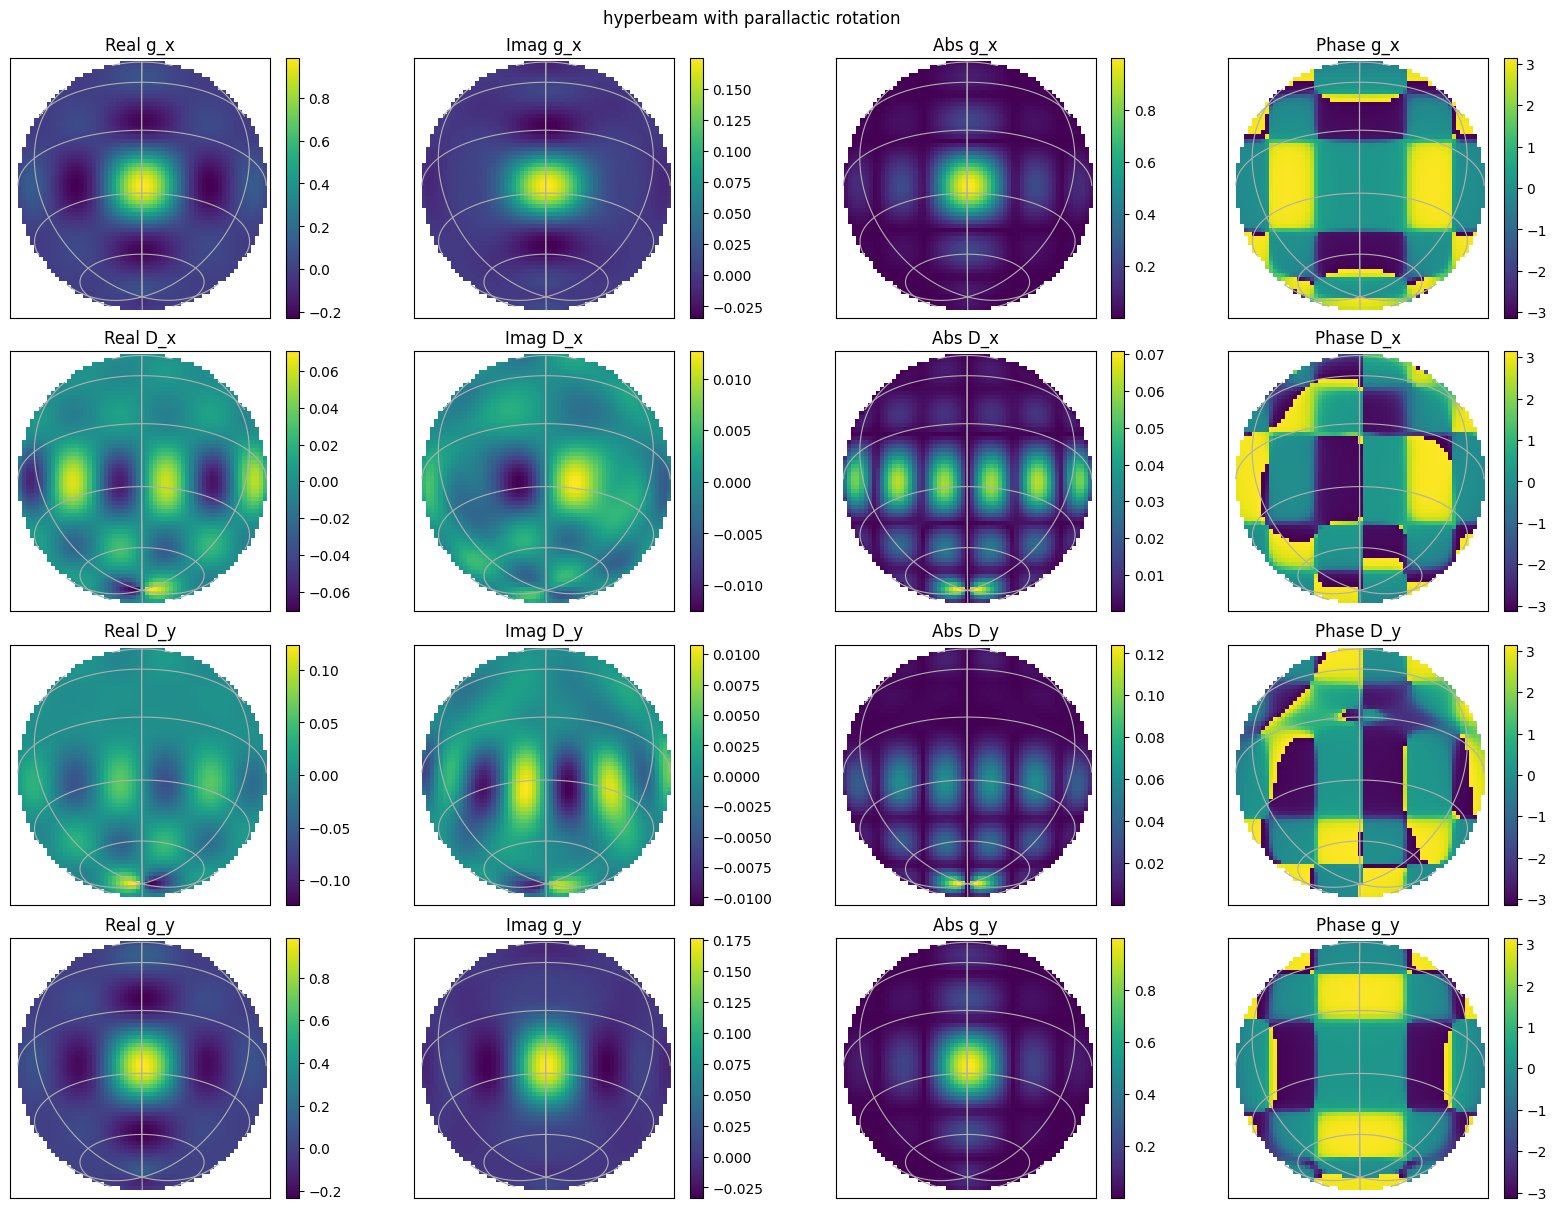

In [15]:
##Set up a grid of RA, Dec points

ra0 = LST_deg
dec0 = MWA_LAT

mjd_current = observing_time.mjd


lst_J2000, latitude_J2000 = RTS_Precess_LST_Lat_to_J2000(np.radians(LST_deg),
                                                         np.radians(MWA_LAT),
                                                         mjd_current)


nside=64
radec_reso=120/nside

header, wcs = create_WCS(ra0, dec0, nside, radec_reso)
x_mesh, y_mesh = np.meshgrid(np.arange(nside), np.arange(nside))
ras, decs = wcs.all_pix2world(x_mesh, y_mesh, 0)

ras = np.radians(ras.flatten())
decs = np.radians(decs.flatten())

##Then use erfa to convert these values into azs, els
# has = np.radians(LST_deg) - ras
has = lst_J2000 - ras

##use this erfa function to convert to azimuth and elevation
##were using degrees, but erfa uses rads, so convert here
az_grid, els = erfa.hd2ae(has, decs, latitude_J2000)
za_grid = np.pi/2 - els

##mwa hyperbeam
beam = mwa_hyperbeam.FEEBeam(hdf5_file=os.environ["MWA_FEE_HDF5"])

##Do it at exactly one of the stored frequencies, so when comparing
##to UVBeam we don't get interpolation differences
freq = 1.8432e+08

parallactic_rotation = True
IAU_order = True

jones = beam.calc_jones_array(az_grid, za_grid, freq, [0]*16, [1]*16,
                              IAU_order, latitude_J2000, parallactic_rotation)

all_gx_hyp = jones[:,0]
all_Dx_hyp = jones[:,1]
all_Dy_hyp = jones[:,2]
all_gy_hyp = jones[:,3]

all_gx_hyp.shape = (nside, nside)
all_Dx_hyp.shape = (nside, nside)
all_Dy_hyp.shape = (nside, nside)
all_gy_hyp.shape = (nside, nside)

plot_jones_on_sky(all_gx_hyp, all_Dx_hyp, all_Dy_hyp, all_gy_hyp, wcs, title="hyperbeam with parallactic rotation")

Do a sanity check that we have polarisations in the order that we want. North dipoles are most sensitive towards the East-West, so if we subtract Y from X, we should see a positive signal towards the East-West, and negative towards the North-South.

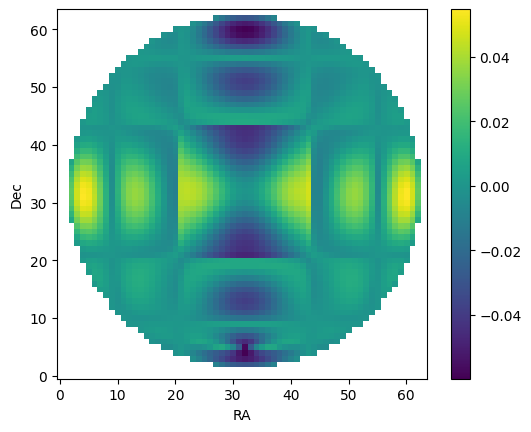

In [16]:
diff = np.abs(all_gx_hyp) - np.abs(all_gy_hyp)
im = plt.imshow(diff, origin='lower')
plt.colorbar(im)
plt.xlabel("RA")
plt.ylabel("Dec")
plt.show()

## `UVBeam` MWA
Righto let's compare that to the wrapper I have written around UVBeam MWA

invalid value encountered in hd2ae


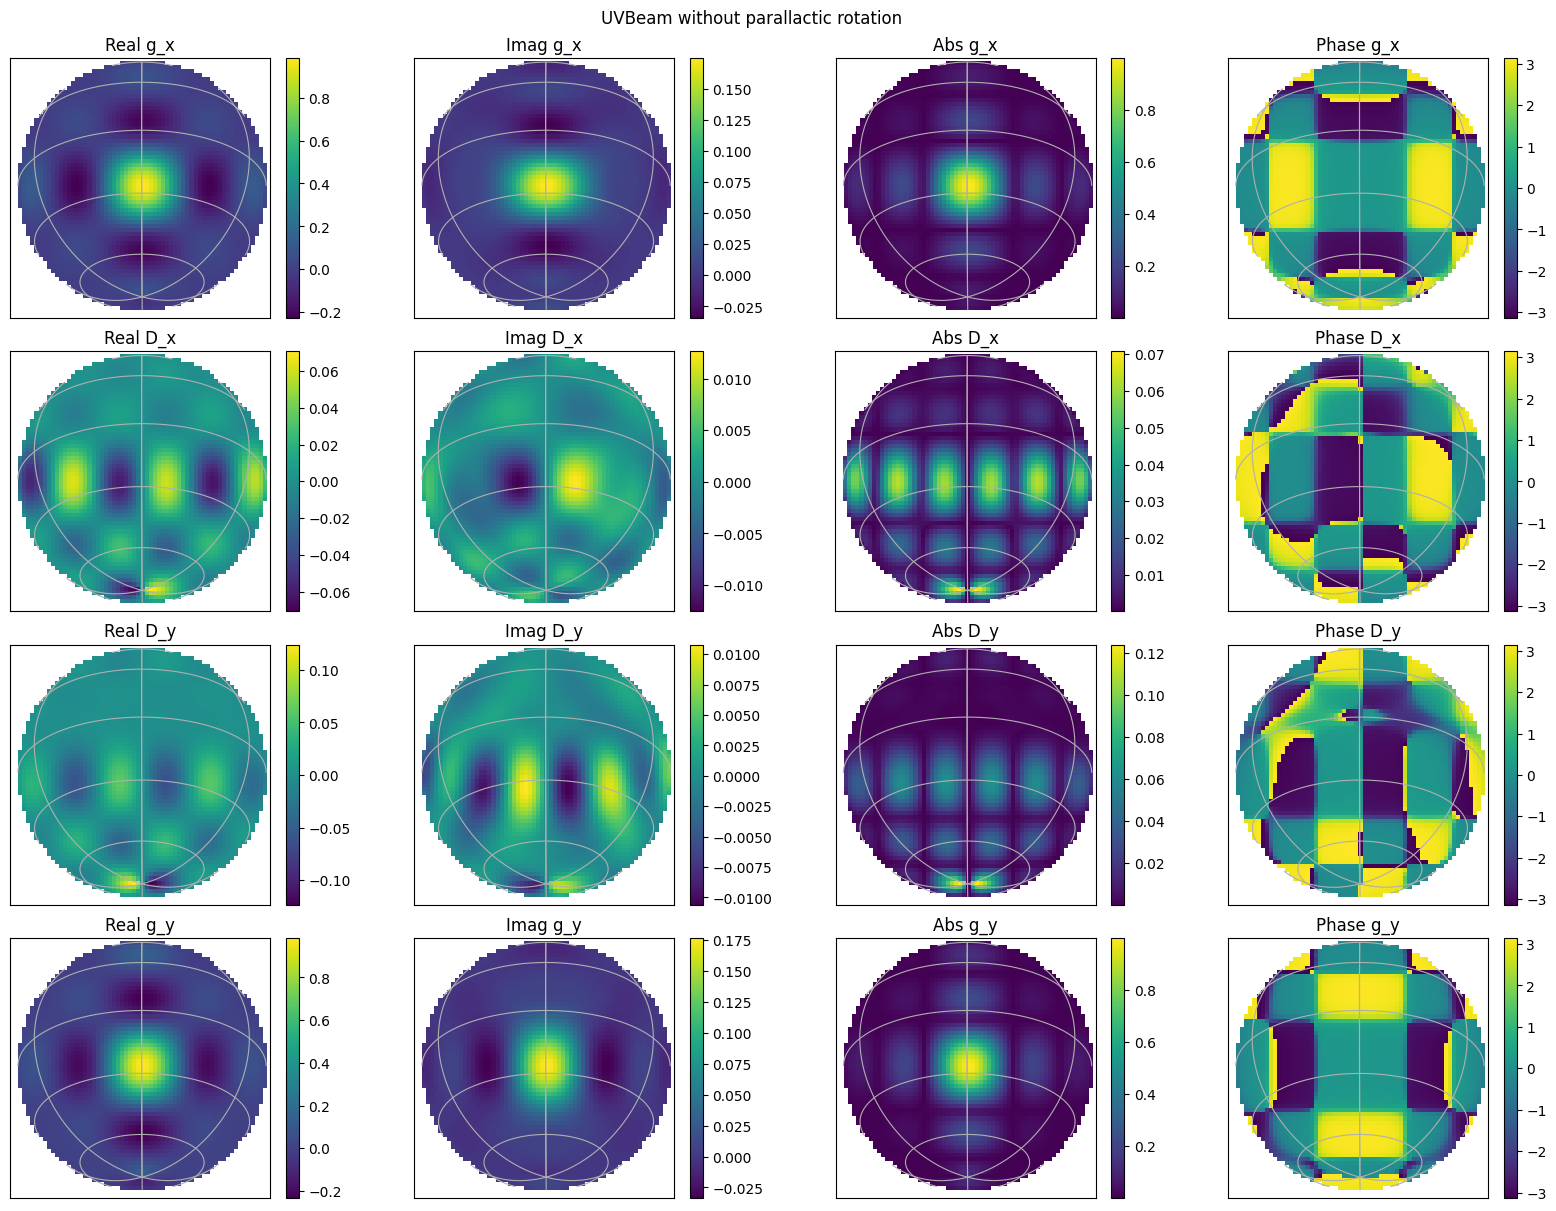

In [17]:
from wodenpy.primary_beam.use_uvbeam import setup_MWA_uvbeams, run_uvbeam


freqs = np.array([freq])

delays = np.zeros(16)
gains = np.ones(32)

uvbeam_objs = setup_MWA_uvbeams(os.environ["MWA_FEE_HDF5"], freqs,
                                delays, gains,
                                pixels_per_deg = 5)

latitudes = np.array([latitude_J2000])
lsts = np.array([lst_J2000])
        
uvbeam_jones = run_uvbeam(uvbeam_objs, ras, decs,
                            latitudes, lsts,
                            freqs, iau_order=True,
                            parallactic_rotate=True)


beam_ind, time_ind, freq_ind = 0, 0, 0

all_gx_uvb = uvbeam_jones[beam_ind, time_ind, freq_ind, :, 0,0]
all_Dx_uvb = uvbeam_jones[beam_ind, time_ind, freq_ind, :, 0,1]
all_Dy_uvb = uvbeam_jones[beam_ind, time_ind, freq_ind, :, 1,0]
all_gy_uvb = uvbeam_jones[beam_ind, time_ind, freq_ind, :, 1,1]

all_gx_uvb.shape = (nside, nside)
all_Dx_uvb.shape = (nside, nside)
all_Dy_uvb.shape = (nside, nside)
all_gy_uvb.shape = (nside, nside)

plot_jones_on_sky(all_gx_uvb, all_Dx_uvb, all_Dy_uvb, all_gy_uvb, wcs, 'UVBeam without parallactic rotation')

Now check that we have the east-west and north-south the way round that we think we do:

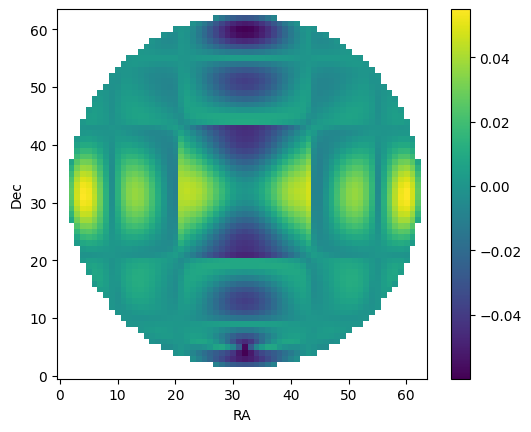

In [18]:
diff = np.abs(all_gx_uvb) - np.abs(all_gy_uvb)
im = plt.imshow(diff, origin='lower')
plt.colorbar(im)
plt.xlabel("RA")
plt.ylabel("Dec")
plt.show()

Good, same as what we got for `hyperdrive`. How different are the two beams?

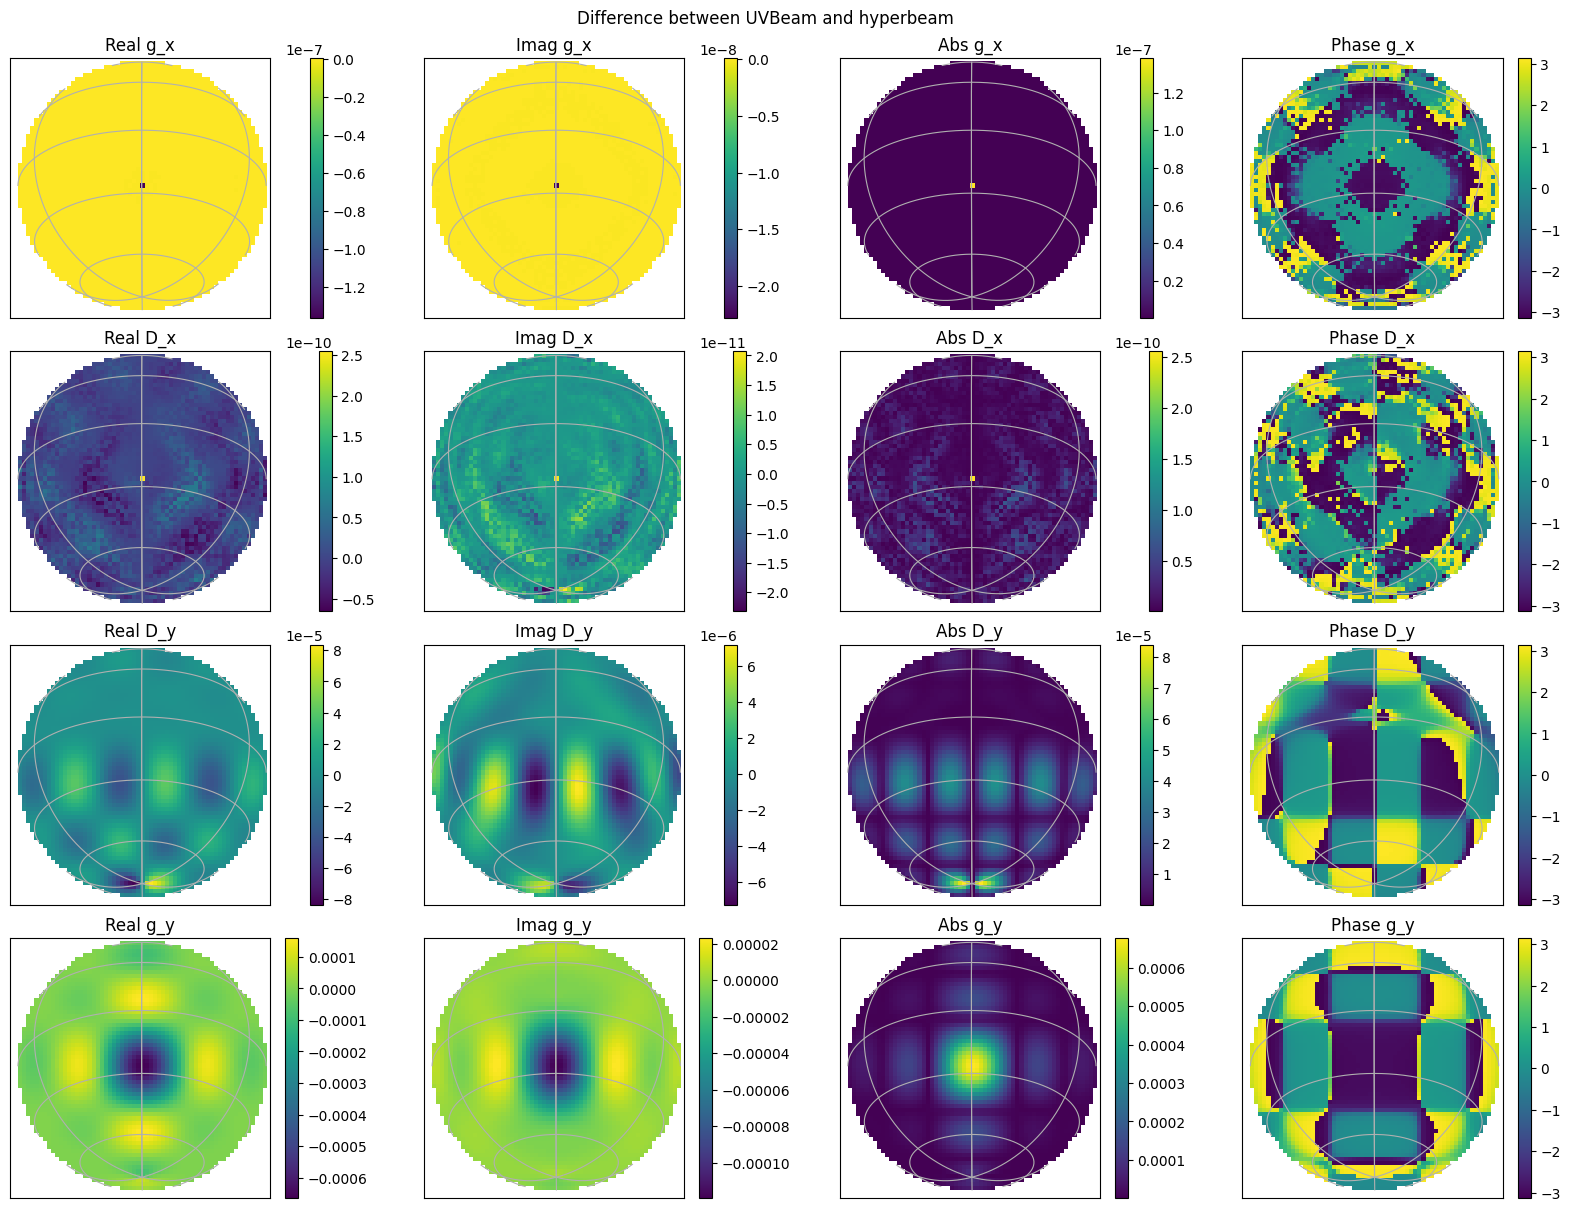

In [19]:
diff_gx = all_gx_uvb - all_gx_hyp
diff_Dx = all_Dx_uvb - all_Dx_hyp
diff_Dy = all_Dy_uvb - all_Dy_hyp
diff_gy = all_gy_uvb - all_gy_hyp

plot_jones_on_sky(diff_gx, diff_Dx, diff_Dy, diff_gy, wcs, 'Difference between UVBeam and hyperbeam')

So there is definitely a normalisation difference between the two beams. I'm using `peak_normalize()` under the hood to normalise `UVBeam`, which gives the closest answer. It is pretty suss that the north-south dipole (the x here, as I'm doing IAU labelling) is near identical, but the east-west dipole (the y here) is not. I'm also doing the parallactic rotation myself under the hood, so maybe that's having an effect?

## Stokes recovery
Now let's check that we can recover the Stokes parameters from the beam. We'll just test a single point source at zenith, where the gains should essentially be 1.0 and leakage zero. We'll run all Stokes of I, Q, U, V through the full simulator, recombine the linear polarisations, and check we get back what we put in.

First, make our sky models. We'll make 4 Stokes I models, where each has either I, Q, U, V = 1, and all other Stokes are zero. To make that happen for Q/U, make the component a list type so explicitly set one or the other to zero.

In [20]:
make_sky_models(ra0, dec0)

Keep the simulations tiny by making a 3 ant array

In [21]:
np.random.seed(234987)

##make a random array layout. Source is at phase centre, so the visibilities
##should all be full real and just be set by the flux in the sky
num_antennas = 3
east = np.random.uniform(-1000, 1000, num_antennas)
north = np.random.uniform(-1000, 1000, num_antennas)
height = np.zeros(num_antennas)

array = np.empty((num_antennas, 3))
array[:,0] = east
array[:,1] = north
array[:,2] = height

array_name = "eg_array.txt"
np.savetxt(array_name, array)

Run the 4 different Stokes sky models through `hyperbeam` first as a point of comparison. Check things work over a broad range of frequencies.


In [26]:
primary_beam = "MWA_FEE"

freq_reso = 1e+6
low_freq = 180e+6
high_freq = 210e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)

for pol in ['I', 'Q', 'U', 'V']:

    uvfits_name = f"stokes{pol}_{primary_beam}"
    cat_name = f'{pol}_source.fits'

    cmd = 'run_woden.py '
    cmd += f'--ra0={ra0} --dec0={dec0} '
    cmd += f'--metafits_filename={metafits} '
    cmd += f'--array_layout={array_name} '
    cmd += f'--output_uvfits_prepend={uvfits_name} '
    cmd += f'--primary_beam={primary_beam} '
    cmd += f'--band_nums=1 '
    cmd += f'--num_time_steps=1 '
    cmd += f'--IAU_order '
    cmd += f'--cat_filename={cat_name} '
    cmd += f'--time_res=2 '
    cmd += f'--freq_res={freq_reso} '
    cmd += f'--lowest_channel_freq={low_freq} '
    cmd += f'--num_freq_channels={num_freq_chans} '
    cmd += f'--num_threads=1 --cpu_mode '
    
    call(cmd, shell=True)

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


2025-04-04 16:20:07 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                                 You are using wodenpy version/git hash: a43c383
                                 
2025-04-04 16:20:07 - INFO - Input arguments after parsing:
                             	Phase centre: 359.79189, -26.70332 deg
                             	Array central latitude: -26.703 deg
                             	Array central longitude: 116.671 deg
             

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


2025-04-04 16:20:10 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                                 You are using wodenpy version/git hash: a43c383
                                 
2025-04-04 16:20:10 - INFO - Input arguments after parsing:
                             	Phase centre: 359.79189, -26.70332 deg
                             	Array central latitude: -26.703 deg
                             	Array central longitude: 116.671 deg
             

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


2025-04-04 16:20:12 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                                 You are using wodenpy version/git hash: a43c383
                                 
2025-04-04 16:20:12 - INFO - Input arguments after parsing:
                             	Phase centre: 359.79189, -26.70332 deg
                             	Array central latitude: -26.703 deg
                             	Array central longitude: 116.671 deg
             

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


2025-04-04 16:20:14 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                                 You are using wodenpy version/git hash: a43c383
                                 
2025-04-04 16:20:14 - INFO - Input arguments after parsing:
                             	Phase centre: 359.79189, -26.70332 deg
                             	Array central latitude: -26.703 deg
                             	Array central longitude: 116.671 deg
             

Tests are defined in `eb_testing_code.py`, which just asserts that whichever Stokes param we set to one comes out as one, and everything else is zero. Make the absolute tolerance of the test something to toggle, because real beam has leakage, and we don't have the beam at exactly the phase centre for `hyperbeam`. The Stokes recovery is only really legit when the XX and YY beams are the same, so it's good at phase centre and zenith.

Do the actual tests for MWA FEE beam

In [27]:
for pol in ['I', 'Q', 'U', 'V']:
    test_stokes_recovery(pol, 'MWA_FEE', atol=5e-3)

Testing Stokes I
Stokes I passed
Testing Stokes Q
Stokes Q passed
Testing Stokes U
Stokes U passed
Testing Stokes V
Stokes V passed


Right, try and do the same thing with `EveryBeam`

In [28]:
primary_beam = "uvbeam_MWA"

freq_reso = 1e+6
low_freq = 180e+6
high_freq = 210e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)

for pol in ['I', 'Q', 'U', 'V']:

    uvfits_name = f"stokes{pol}_{primary_beam}"
    cat_name = f'{pol}_source.fits'

    cmd = 'run_woden.py '
    cmd += f'--ra0={ra0} --dec0={dec0} '
    cmd += f'--metafits_filename={metafits} '
    cmd += f'--array_layout={array_name} '
    cmd += f'--output_uvfits_prepend={uvfits_name} '
    cmd += f'--primary_beam={primary_beam} '
    cmd += f'--band_nums=1 '
    cmd += f'--num_time_steps=1 '
    cmd += f'--IAU_order '
    cmd += f'--cat_filename={cat_name} '
    cmd += f'--time_res=2 '
    cmd += f'--freq_res={freq_reso} '
    cmd += f'--lowest_channel_freq={low_freq} '
    cmd += f'--num_freq_channels={num_freq_chans} '
    cmd += f'--num_threads=1 --cpu_mode '
    
    call(cmd, shell=True)

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


2025-04-04 16:20:47 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                                 You are using wodenpy version/git hash: a43c383
                                 
2025-04-04 16:20:47 - INFO - Input arguments after parsing:
                             	Phase centre: 359.79189, -26.70332 deg
                             	Array central latitude: -26.703 deg
                             	Array central longitude: 116.671 deg
             

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


2025-04-04 16:21:19 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                                 You are using wodenpy version/git hash: a43c383
                                 
2025-04-04 16:21:19 - INFO - Input arguments after parsing:
                             	Phase centre: 359.79189, -26.70332 deg
                             	Array central latitude: -26.703 deg
                             	Array central longitude: 116.671 deg
             

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


2025-04-04 16:21:50 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                                 You are using wodenpy version/git hash: a43c383
                                 
2025-04-04 16:21:50 - INFO - Input arguments after parsing:
                             	Phase centre: 359.79189, -26.70332 deg
                             	Array central latitude: -26.703 deg
                             	Array central longitude: 116.671 deg
             

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


2025-04-04 16:22:23 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                                 You are using wodenpy version/git hash: a43c383
                                 
2025-04-04 16:22:23 - INFO - Input arguments after parsing:
                             	Phase centre: 359.79189, -26.70332 deg
                             	Array central latitude: -26.703 deg
                             	Array central longitude: 116.671 deg
             

In [29]:
for pol in ['I', 'Q', 'U', 'V']:
    test_stokes_recovery(pol, 'uvbeam_MWA', atol=5e-3)
    
    # #Uncomment to print out example values
    # uvfits_name = f"stokes{pol}_everybeam_MWA"
    # XX, XY, YX, YY = read_uvfits(f'{uvfits_name}_band01.uvfits')
    # ##pick a random baseline to plot, they should all be the sam
    # baseline = 0

    # recover_I, recover_Q, recover_U, recover_V = convert_inst_to_stokes(XX[baseline], XY[baseline], YX[baseline], YY[baseline])
    # print(f"{pol}, {recover_I[0].real:.2f}, {recover_Q[0].real:.2f}, {recover_U[0].real:.2f}, {recover_V[0].real:.2f}")

Testing Stokes I
Stokes I passed
Testing Stokes Q
Stokes Q passed
Testing Stokes U
Stokes U passed
Testing Stokes V
Stokes V passed


## Now test an RM recovery
Check we recover the correct RM and sign for a linearly polarised source. First of all, make the sky model.

In [30]:
phi_RM, pol_frac = make_RM_skymodel(ra0, dec0)

Run that through WODEN using `hyperbeam` to check the test is working.

In [34]:
freq_reso = 0.1e+6
low_freq = 180e+6
high_freq = 210e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)


primary_beam = "MWA_FEE"

uvfits_name = f"rm_source_{primary_beam}"
cat_name = 'RM_source.fits'

cmd = 'run_woden.py '

cmd += f'--ra0={ra0} '
cmd += f'--dec0={dec0} '
cmd += f'--array_layout={array_name} '
cmd += f'--metafits_filename={metafits} '
cmd += f'--output_uvfits_prepend={uvfits_name} '
cmd += f'--primary_beam={primary_beam} '
cmd += f'--freq_res={freq_reso} '
cmd += f'--band_nums=1 '
cmd += f'--num_time_steps=1 '
cmd += f'--IAU_order '
cmd += f'--cat_filename={cat_name} '
cmd += f'--lowest_channel_freq={low_freq} '
cmd += f'--num_freq_channels={num_freq_chans} '
cmd += f'--time_res=2 '
cmd += f'--num_threads=1 --cpu_mode'


call(cmd, shell=True)    

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


2025-04-04 16:23:58 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                                 You are using wodenpy version/git hash: a43c383
                                 
2025-04-04 16:23:58 - INFO - Input arguments after parsing:
                             	Phase centre: 359.79189, -26.70332 deg
                             	Array central latitude: -26.703 deg
                             	Array central longitude: 116.671 deg
             

0

Have a look and check our visis make sense

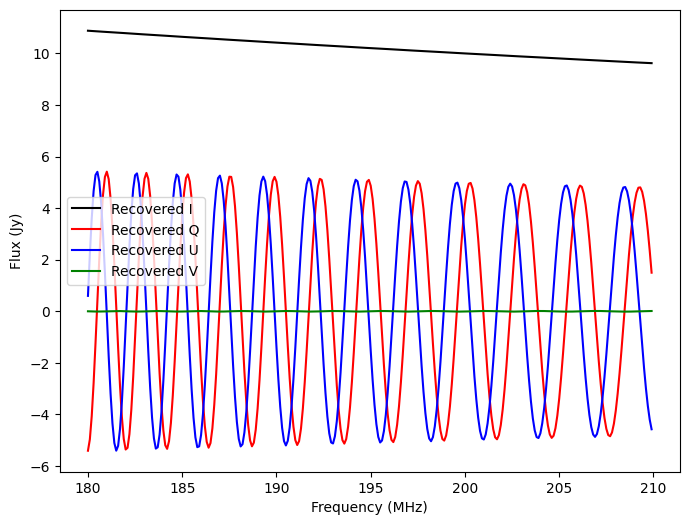

In [35]:
XX, XY, YX, YY = read_uvfits('rm_source_MWA_FEE_band01.uvfits')
baseline = 0    
recover_I, recover_Q, recover_U, recover_V = convert_inst_to_stokes(XX[baseline], XY[baseline], YX[baseline], YY[baseline])

    
freqs = np.arange(low_freq, high_freq, freq_reso)

fig, axs = plt.subplots(1, 1, figsize=(8, 6))

axs.plot(freqs / 1e+6, recover_I.real, 'k-', label='Recovered I')
axs.plot(freqs / 1e+6, recover_Q.real, 'r', label='Recovered Q')
axs.plot(freqs / 1e+6, recover_U.real, 'b', label='Recovered U')
axs.plot(freqs / 1e+6, recover_V.real, 'g', label='Recovered V')

axs.legend()

axs.set_xlabel('Frequency (MHz)')
axs.set_ylabel('Flux (Jy)')

plt.show()

# fig, axs = plt.subplots(1, 1, figsize=(8, 6))
# axs.plot(freqs / 1e+6, recover_I.real, 'k-', label='Polarisation Fraction')

Now define a test, using a bunch of Emil's RM synthesis code. 

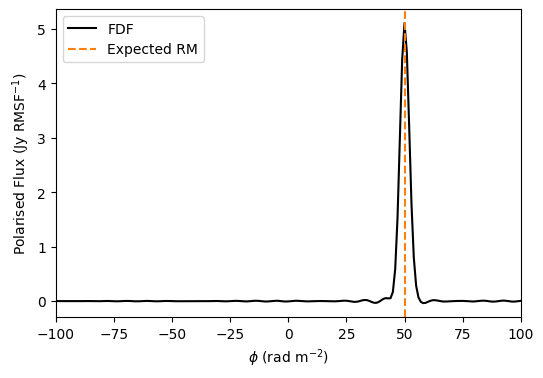

Recovered RM: 50.0 Expected RM: 50
Recovered Pol. Fraction: 0.49999502 Expected Pol Fraction 0.5


In [36]:
test_RM_recovery(uvfits_name, phi_RM, pol_frac, freqs)

Loverly, works a treat. Now let's do that with `EveryBeam`. Fair warning here; doing this many frequencies with `UVBeam` needed like 25GB of RAM. Not entirely sure why, must have something to do with the interpolation over frequency.

In [37]:
freq_reso = 0.1e+6
low_freq = 180e+6
high_freq = 210e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)


primary_beam = "uvbeam_MWA"

uvfits_name = f"rm_source_{primary_beam}"
cat_name = 'RM_source.fits'

cmd = 'run_woden.py '

cmd += f'--ra0={ra0} '
cmd += f'--dec0={dec0} '
cmd += f'--array_layout={array_name} '
cmd += f'--metafits_filename={metafits} '
cmd += f'--output_uvfits_prepend={uvfits_name} '
cmd += f'--primary_beam={primary_beam} '
cmd += f'--freq_res={freq_reso} '
cmd += f'--band_nums=1 '
cmd += f'--num_time_steps=1 '
cmd += f'--IAU_order '
cmd += f'--cat_filename={cat_name} '
cmd += f'--lowest_channel_freq={low_freq} '
cmd += f'--num_freq_channels={num_freq_chans} '
cmd += f'--time_res=2 '
cmd += f'--num_threads=1 --cpu_mode'


call(cmd, shell=True)    

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


2025-04-04 16:24:25 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                                 You are using wodenpy version/git hash: a43c383
                                 
2025-04-04 16:24:25 - INFO - Input arguments after parsing:
                             	Phase centre: 359.79189, -26.70332 deg
                             	Array central latitude: -26.703 deg
                             	Array central longitude: 116.671 deg
             

0

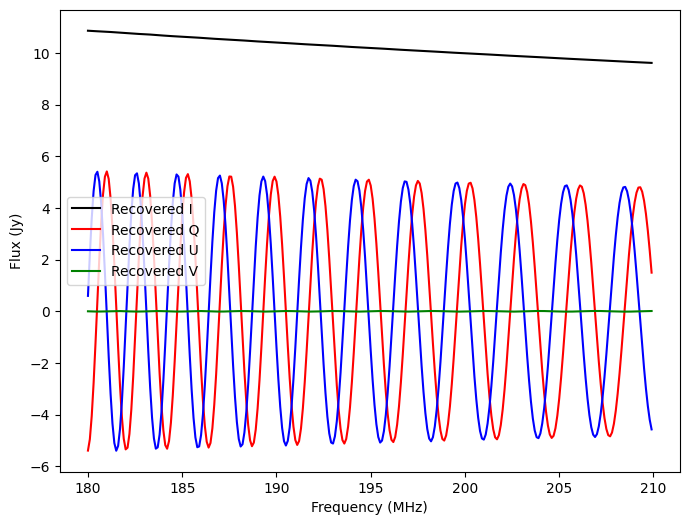

In [39]:
XX, XY, YX, YY = read_uvfits('rm_source_uvbeam_MWA_band01.uvfits')
baseline = 0    
recover_I, recover_Q, recover_U, recover_V = convert_inst_to_stokes(XX[baseline], XY[baseline], YX[baseline], YY[baseline])

    
freqs = np.arange(low_freq, high_freq, freq_reso)

fig, axs = plt.subplots(1, 1, figsize=(8, 6))

axs.plot(freqs / 1e+6, recover_I.real, 'k-', label='Recovered I')
axs.plot(freqs / 1e+6, recover_Q.real, 'r', label='Recovered Q')
axs.plot(freqs / 1e+6, recover_U.real, 'b', label='Recovered U')
axs.plot(freqs / 1e+6, recover_V.real, 'g', label='Recovered V')

axs.legend()

axs.set_xlabel('Frequency (MHz)')
axs.set_ylabel('Flux (Jy)')

plt.show()

Looks good!

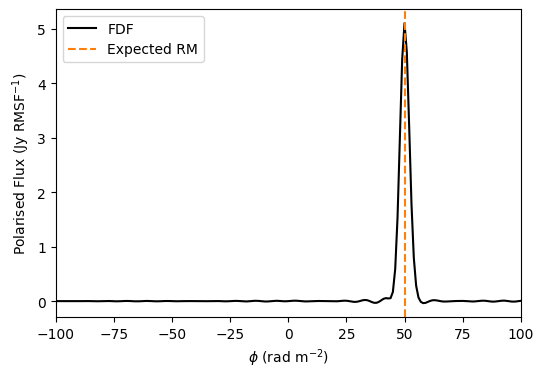

Recovered RM: 50.0 Expected RM: 50
Recovered Pol. Fraction: 0.49999446 Expected Pol Fraction 0.5


In [40]:
test_RM_recovery(uvfits_name, phi_RM, pol_frac, freqs)

Yup works woot

## Try off zenith pointings
Now we'll test whether we can do off-zenith pointings. We'll also test that we can run multiple time steps and frequencies. The measurement set I'm using is real calibrated data from the MWA. Unfortunately, it's 2GB, so there's no good way to include that with the `WODEN` repo. If you want to run this test, you should be able to get some data from the MWA ASVO https://asvo.mwatelescope.org/, and then convert that into a measurement set using `pyuvdata` for example.

In [42]:

ra0 = 60.0
dec0 = -30.0
date = "2015-09-10T19:44:15"
observing_time = Time(date, scale='utc', location=mwa_location)

##Setup a grid of RA/Dec on the sky
nside=50
radec_reso = 120/nside

header, wcs = create_WCS(ra0, dec0, nside, radec_reso)
x_mesh, y_mesh = np.meshgrid(np.arange(nside), np.arange(nside))
ras, decs = wcs.all_pix2world(x_mesh, y_mesh, 0)

ras = np.radians(ras.flatten())
decs = np.radians(decs.flatten())

num_comps = len(ras)

##Do a single freqs and time and beam
all_freqs = np.array([100e+6, 200e+6])
all_times = np.array([observing_time, observing_time + TimeDelta(2*3600.0, format='sec')])

lsts = []
latitudes = []

for obs_time in all_times:
    
    LST = obs_time.sidereal_time('mean')
    lst_current = np.radians(LST.value*15)
    
    lst_J2000, latitude_J2000 = RTS_Precess_LST_Lat_to_J2000(
                                lst_current,
                                np.radians(MWA_LAT),
                                obs_time.mjd)
    
    lsts.append(lst_J2000)
    latitudes.append(latitude_J2000)


delays = np.array([0,2,4,6,0,2,4,6,0,2,4,6,0,2,4,6])

iau_order = True
parallactic_rotate = True


uvbeam_objs = setup_MWA_uvbeams(os.environ["MWA_FEE_HDF5"], all_freqs,
                                delays=delays, 
                                pixels_per_deg = 5)

all_jones = run_uvbeam(uvbeam_objs, ras, decs,
                        latitudes, lsts,
                        all_freqs, iau_order=iau_order,
                        parallactic_rotate=parallactic_rotate)

invalid value encountered in hd2ae


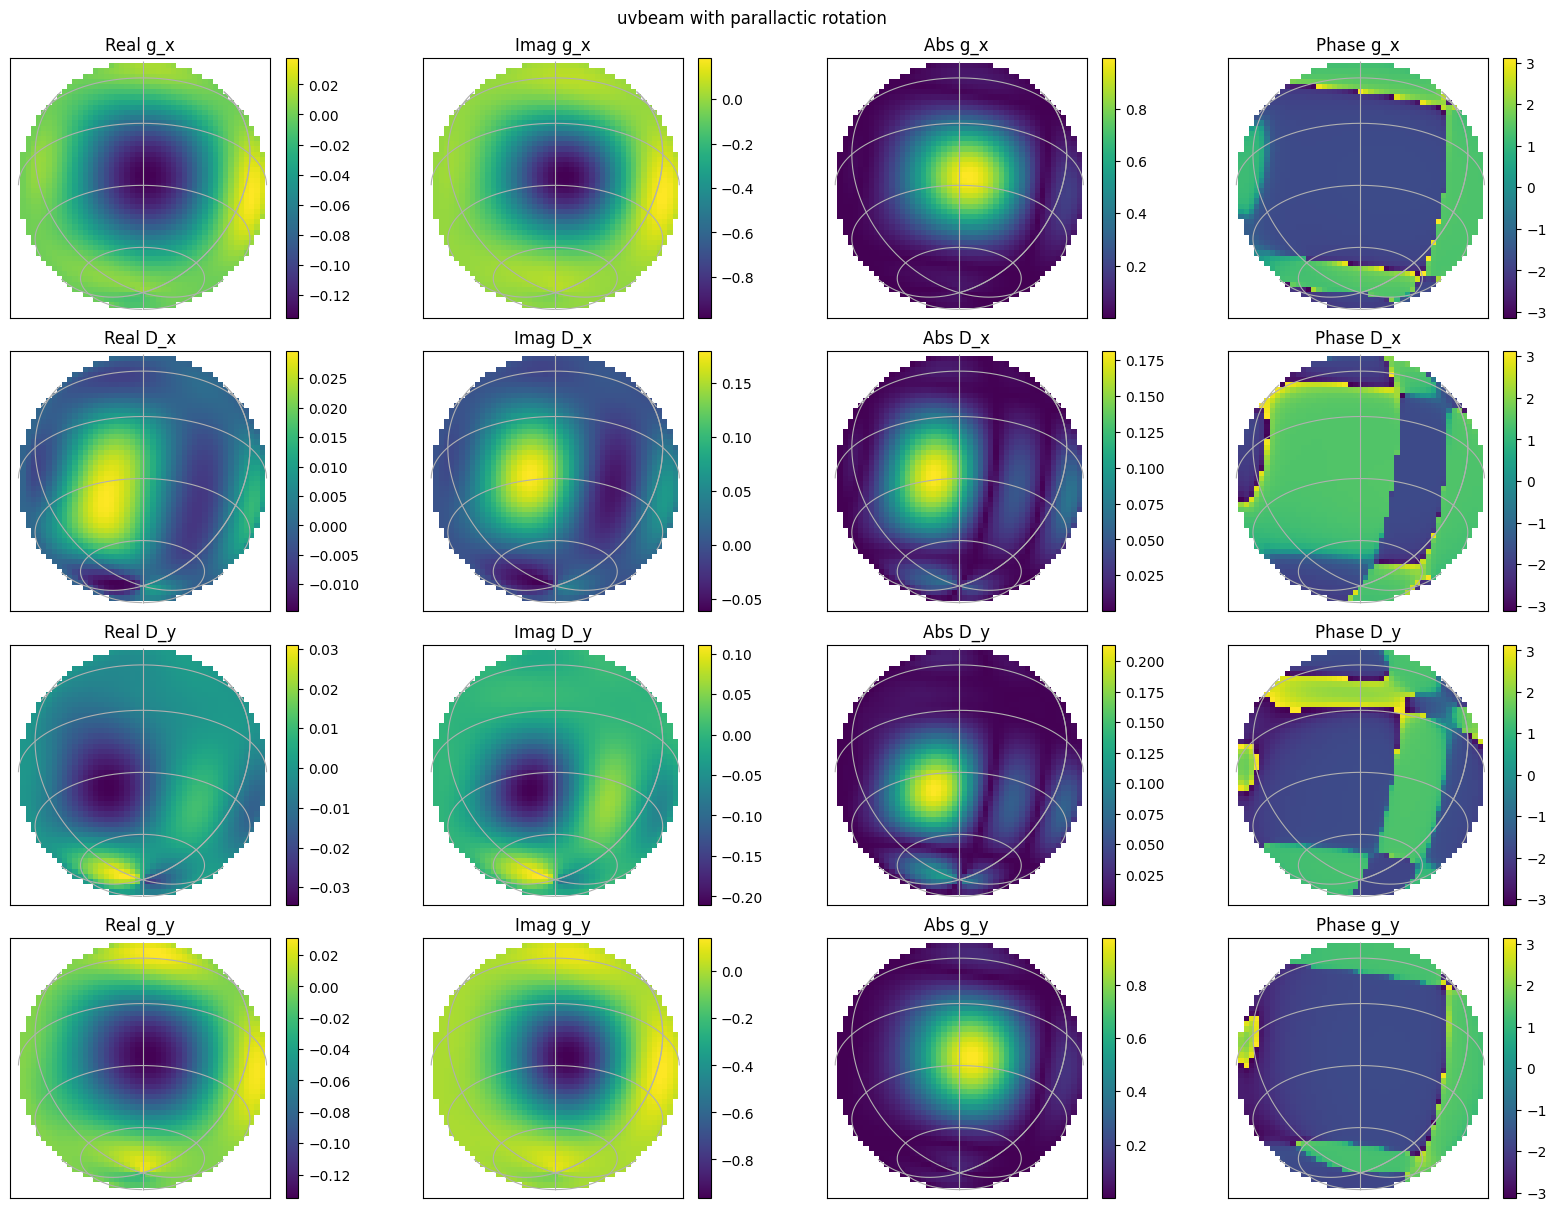

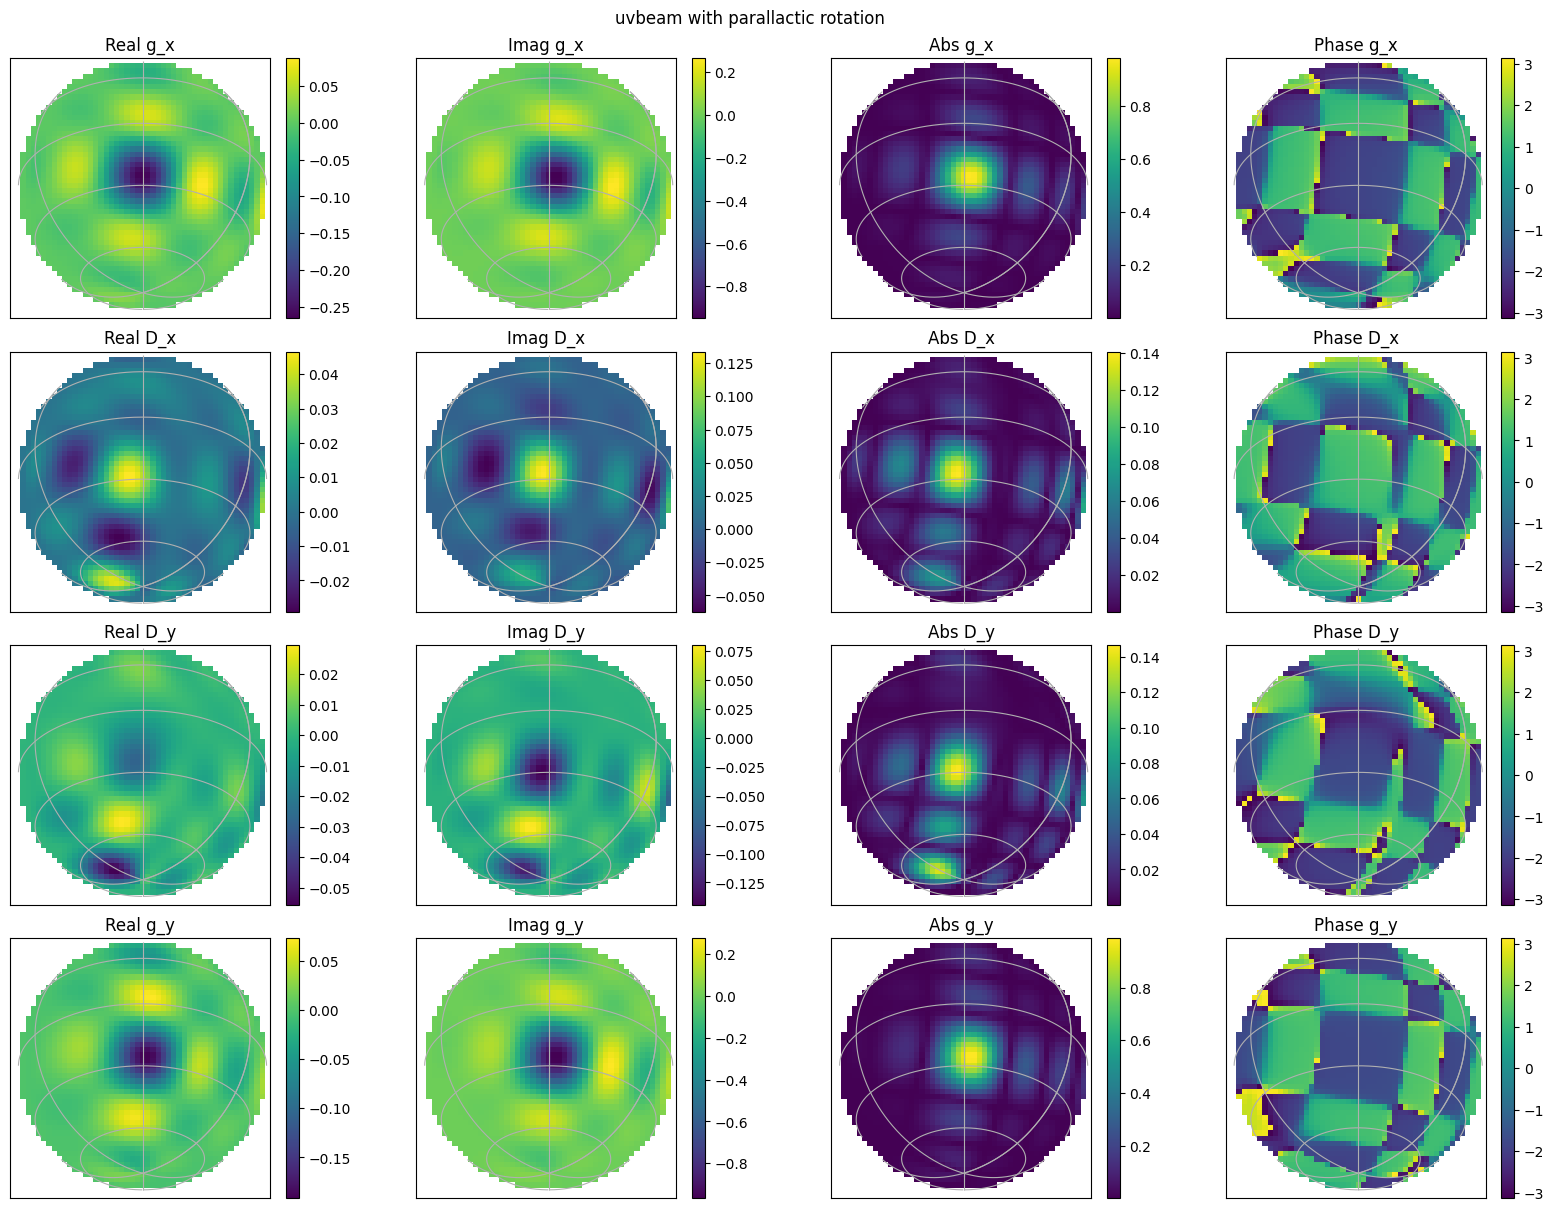

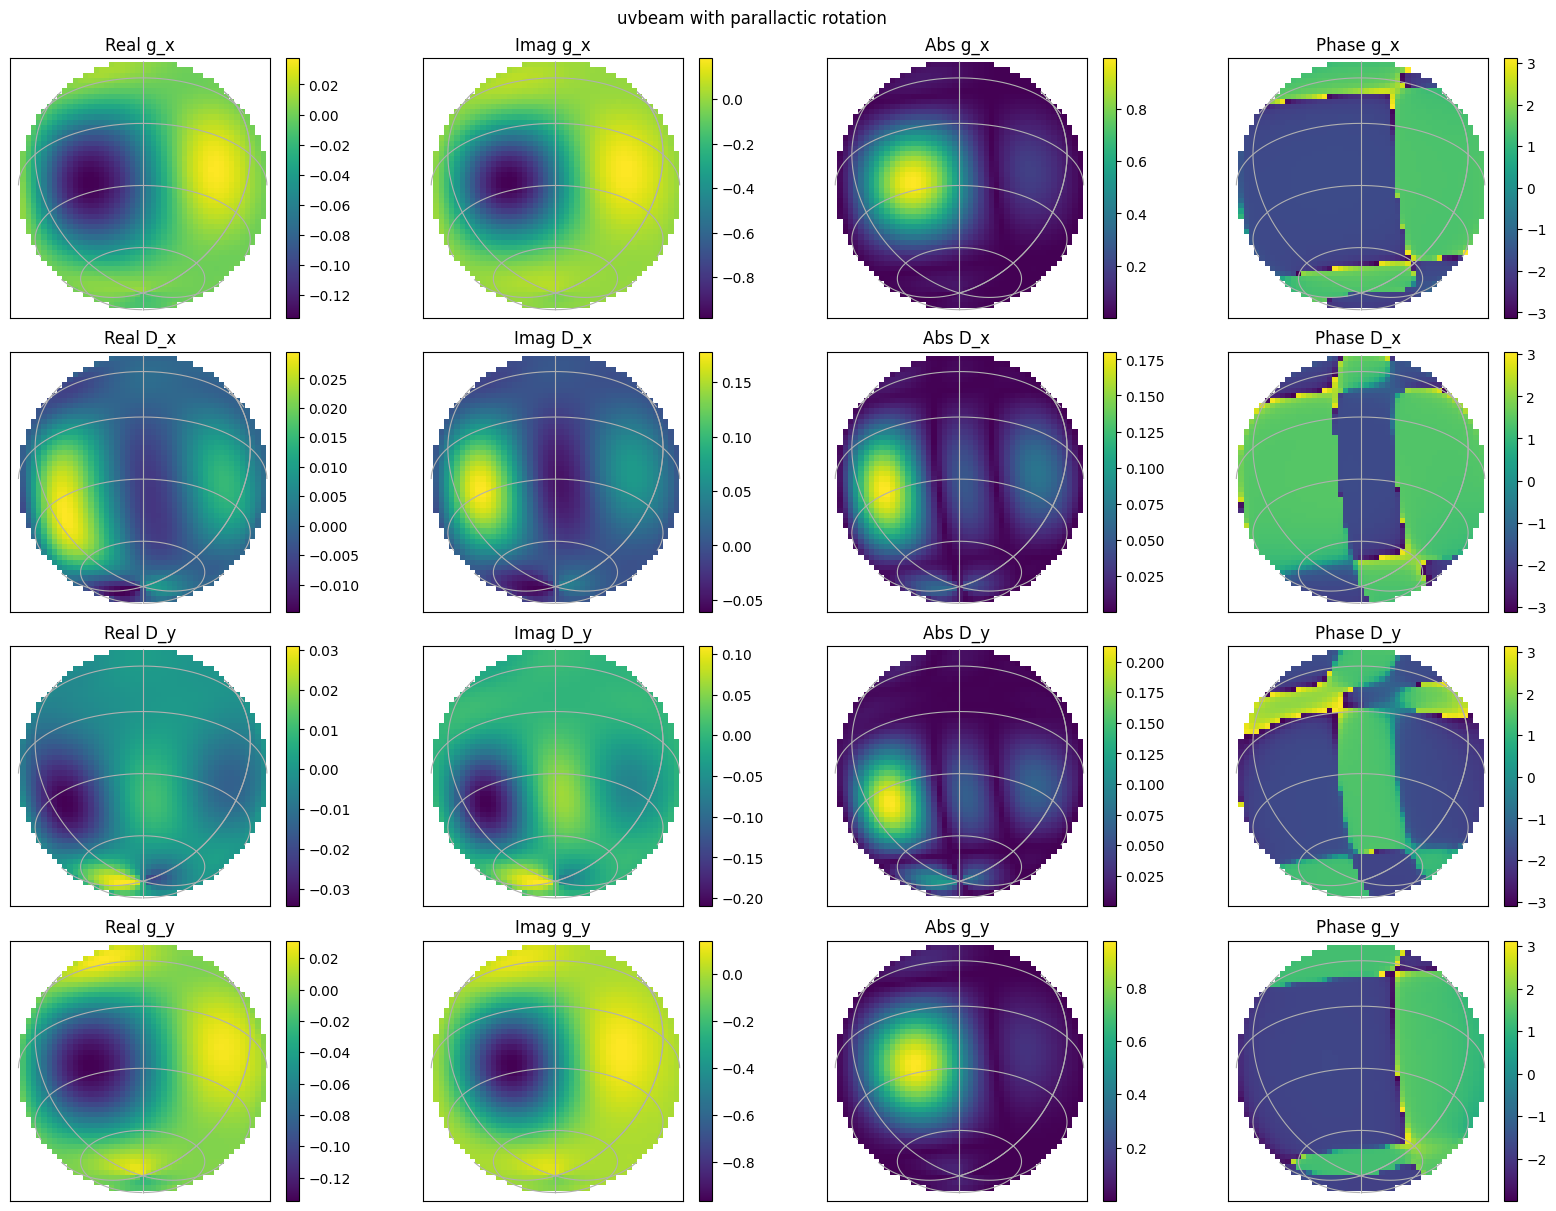

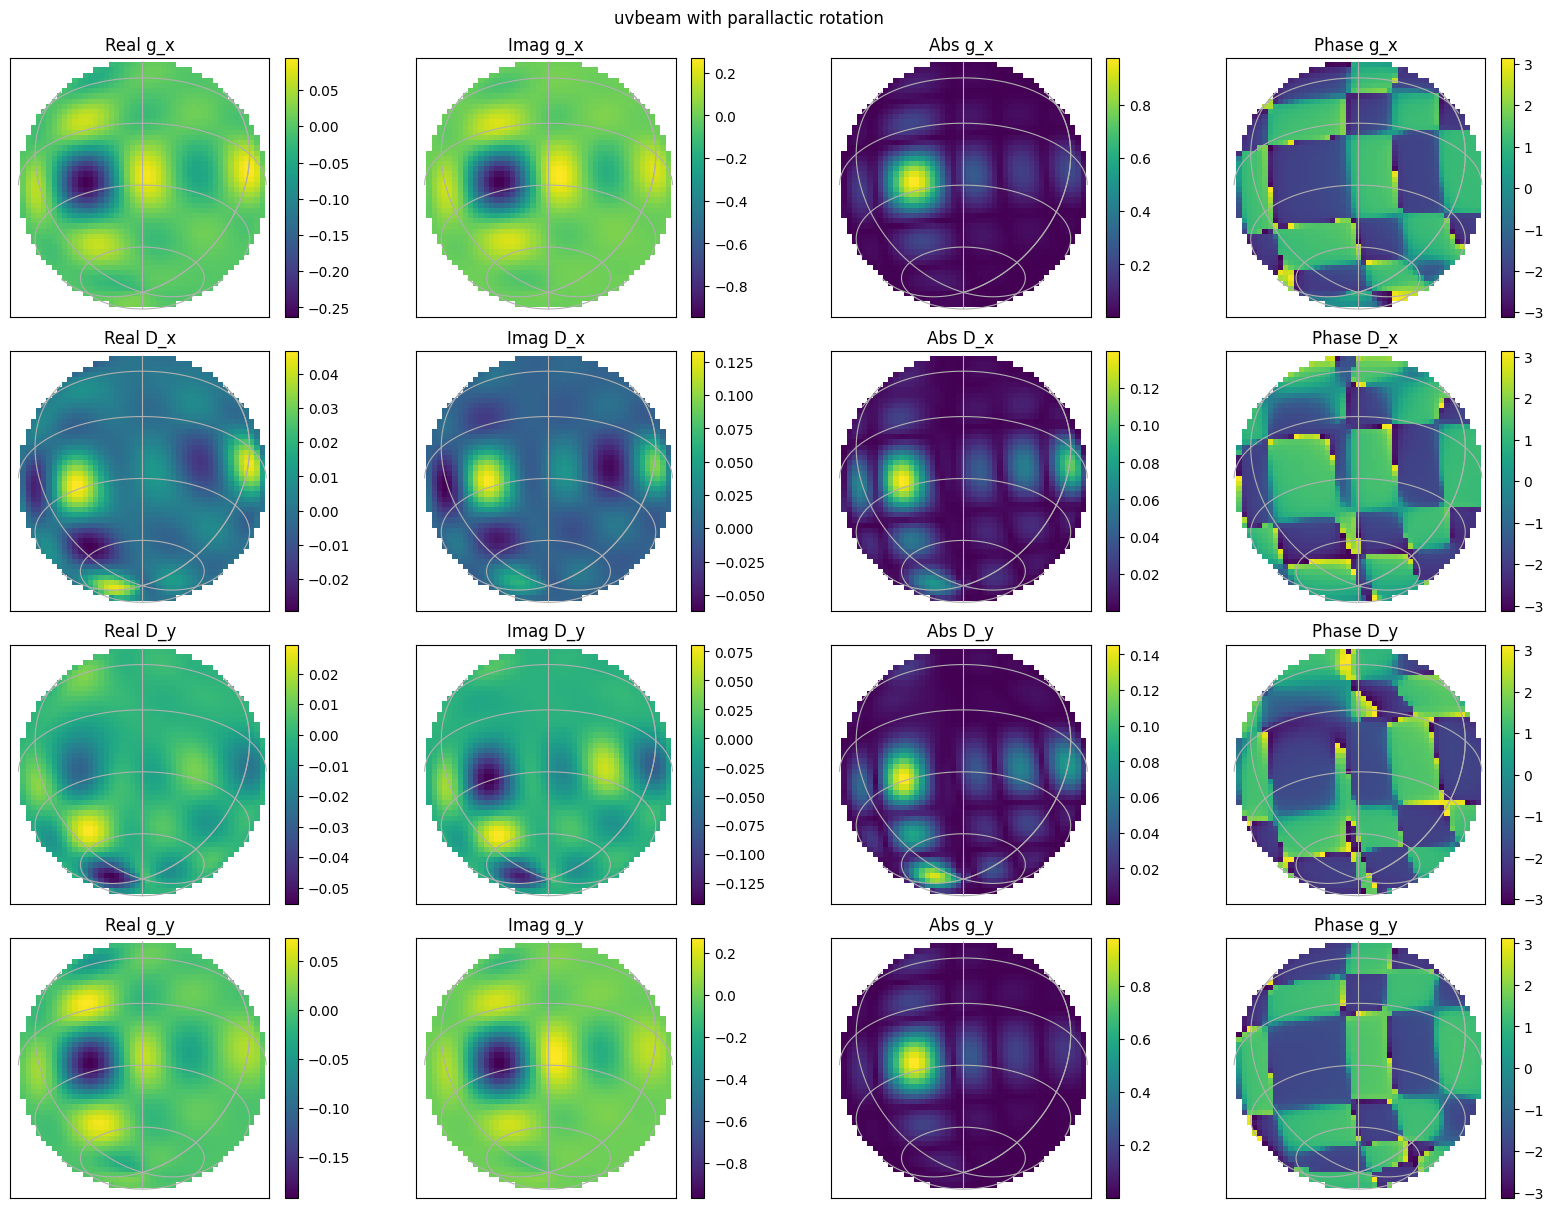

In [53]:
beam_ind = 0

for time_ind in range(len(all_times)):
    for freq_ind in range(len(all_freqs)):
        this_gx = all_jones[beam_ind, time_ind, freq_ind, :, 0, 0]
        this_Dx = all_jones[beam_ind, time_ind, freq_ind, :, 0, 1]
        this_Dy = all_jones[beam_ind, time_ind, freq_ind, :, 1, 0]
        this_gy = all_jones[beam_ind, time_ind, freq_ind, :, 1, 1]

        this_gx.shape = (nside, nside)
        this_Dx.shape = (nside, nside)
        this_Dy.shape = (nside, nside)
        this_gy.shape = (nside, nside)

        plot_jones_on_sky(this_gx, this_Dx, this_Dy, this_gy, wcs, title="uvbeam with parallactic rotation")

Double check what it should look like using `hyperdrive`, where we can explicitly put the delays that we want in.

invalid value encountered in hd2ae


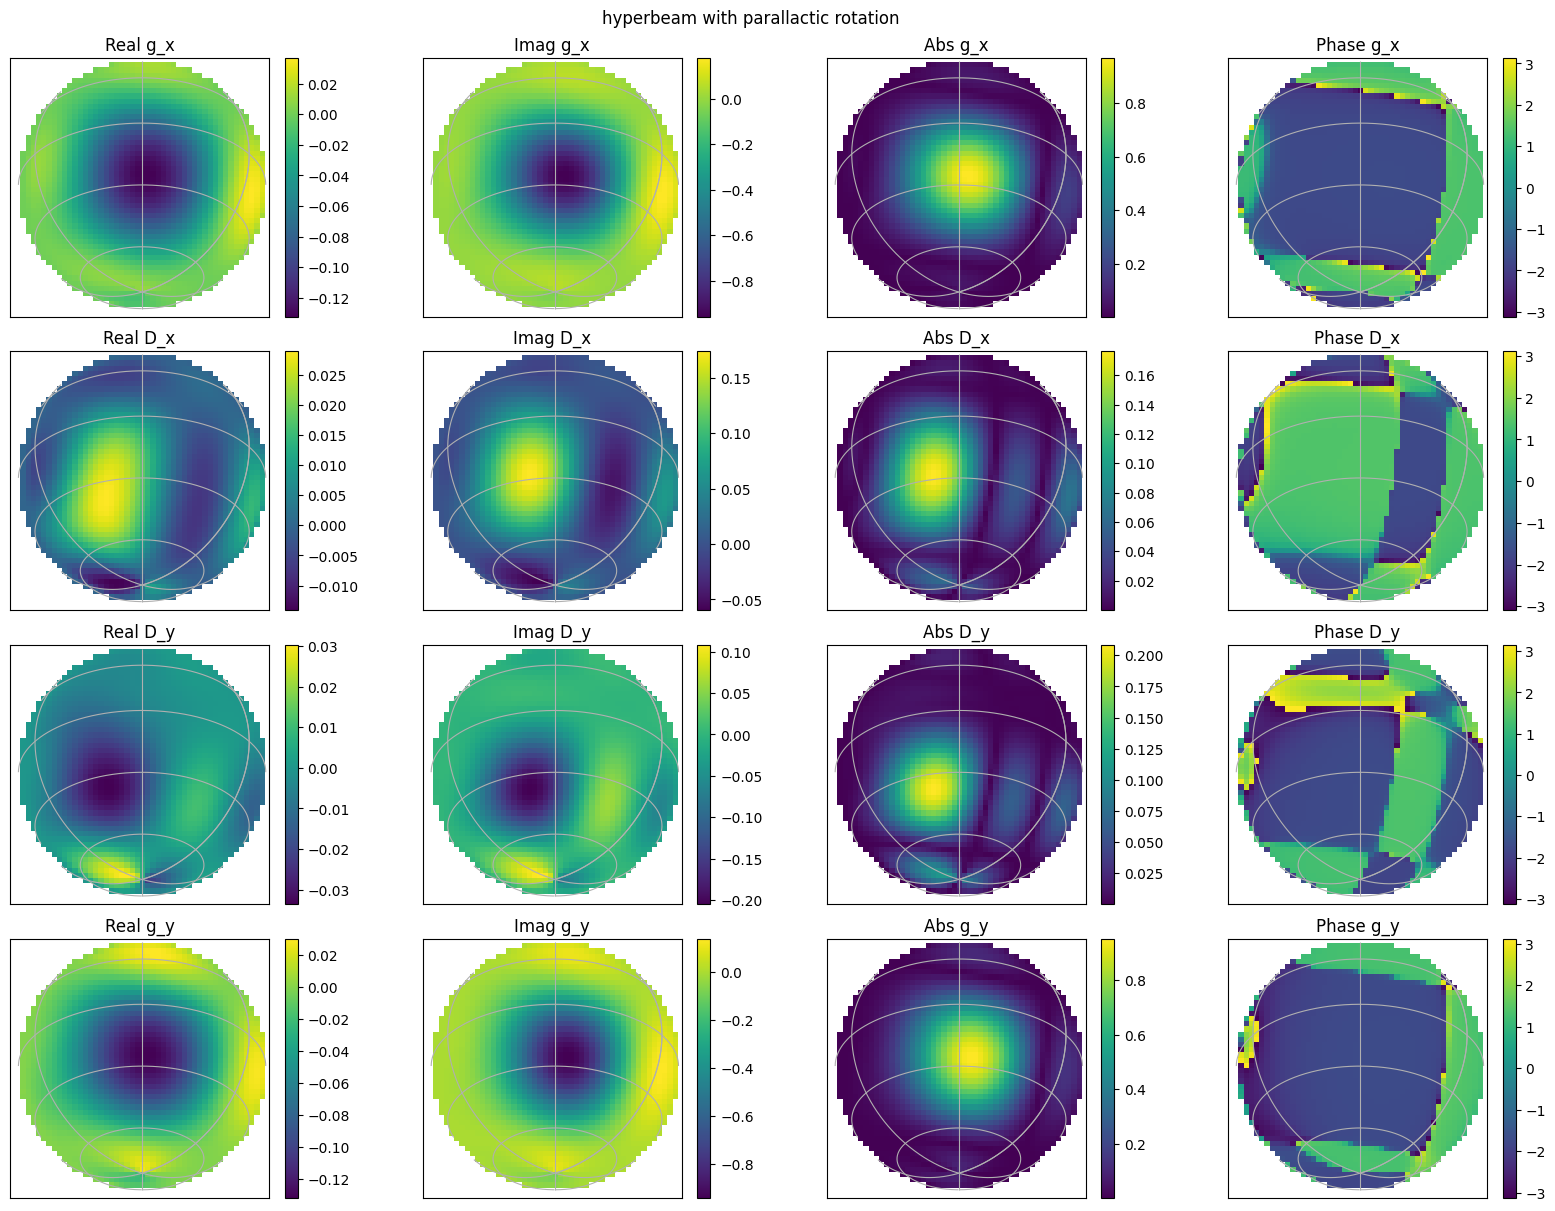

invalid value encountered in hd2ae


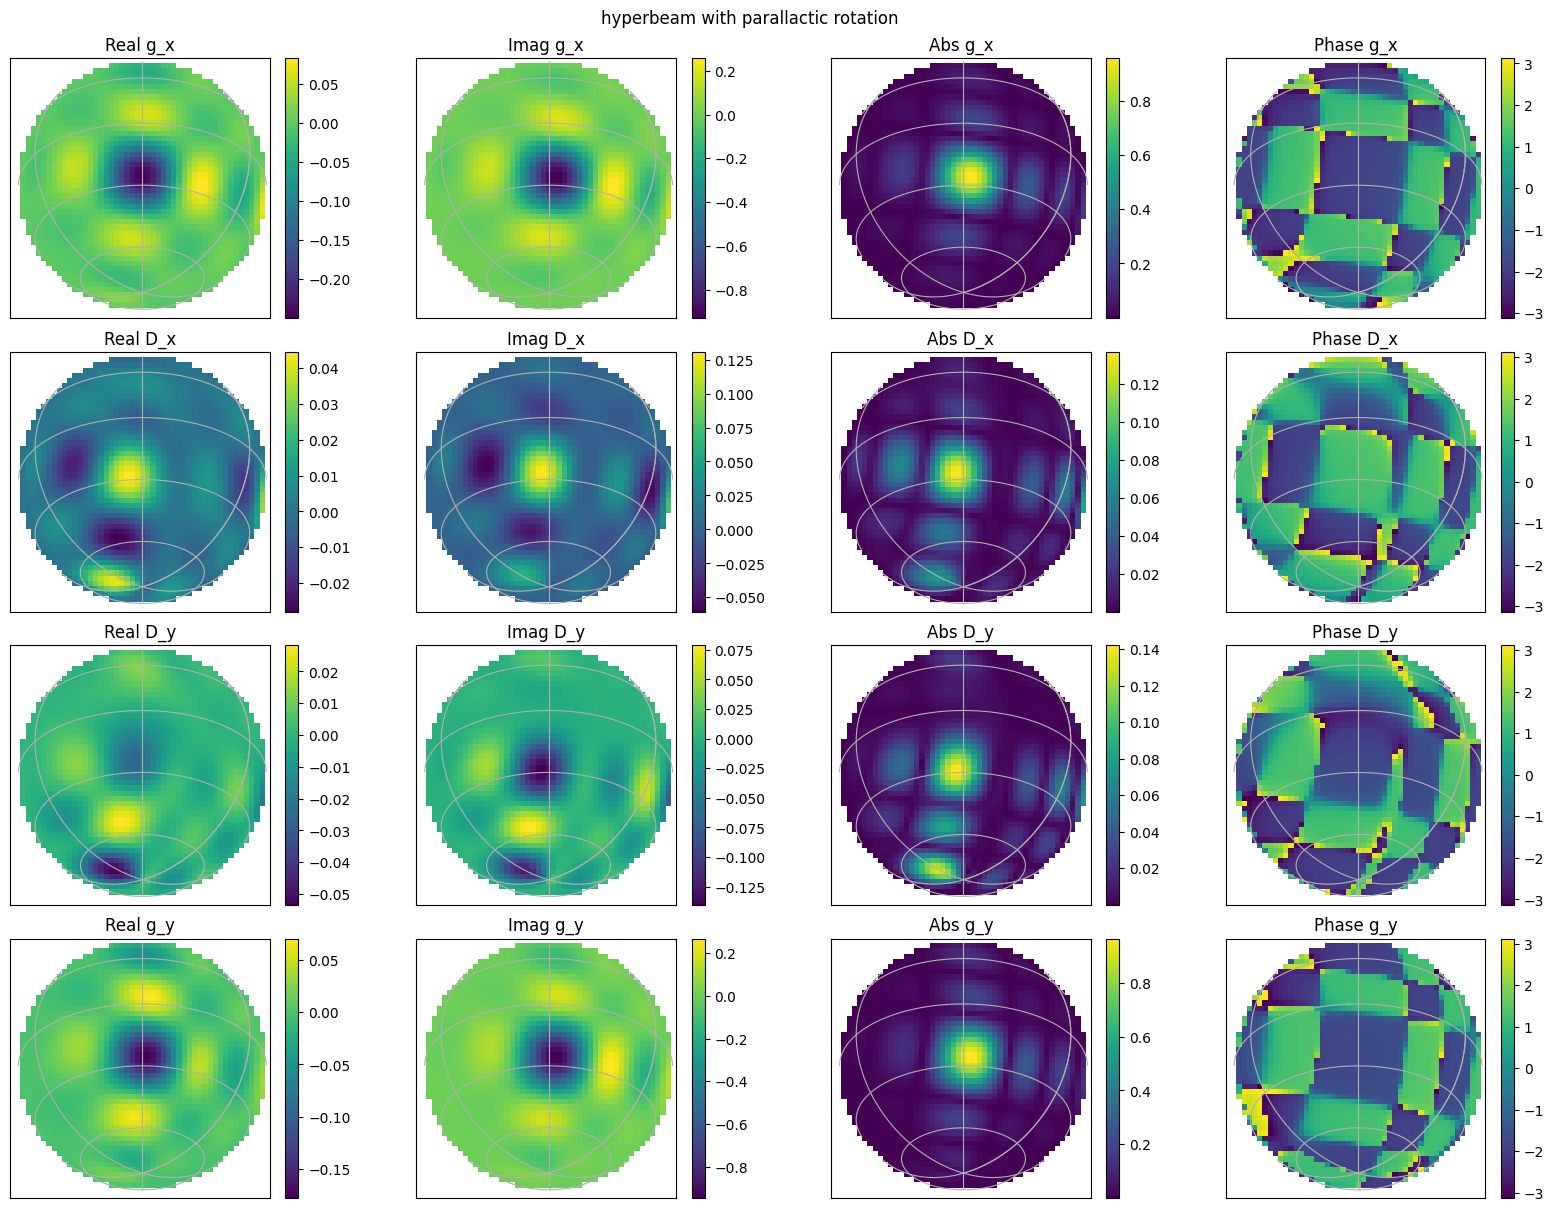

invalid value encountered in hd2ae


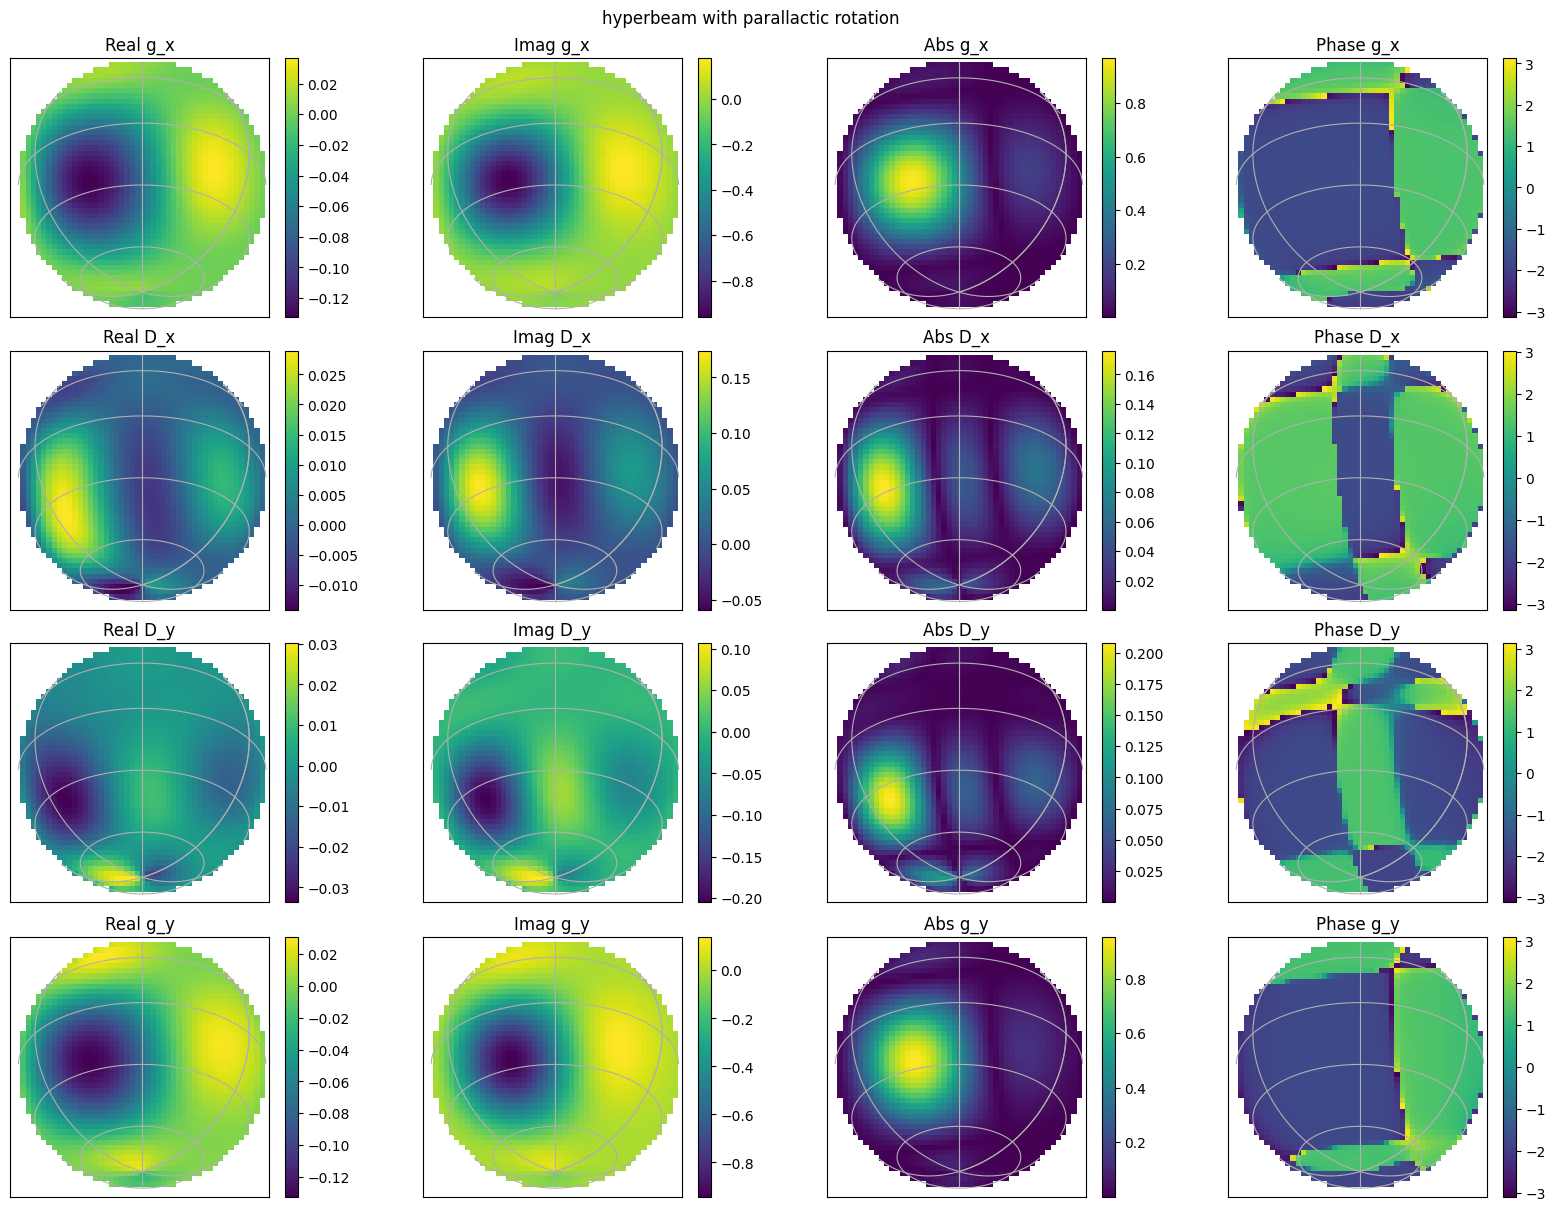

invalid value encountered in hd2ae


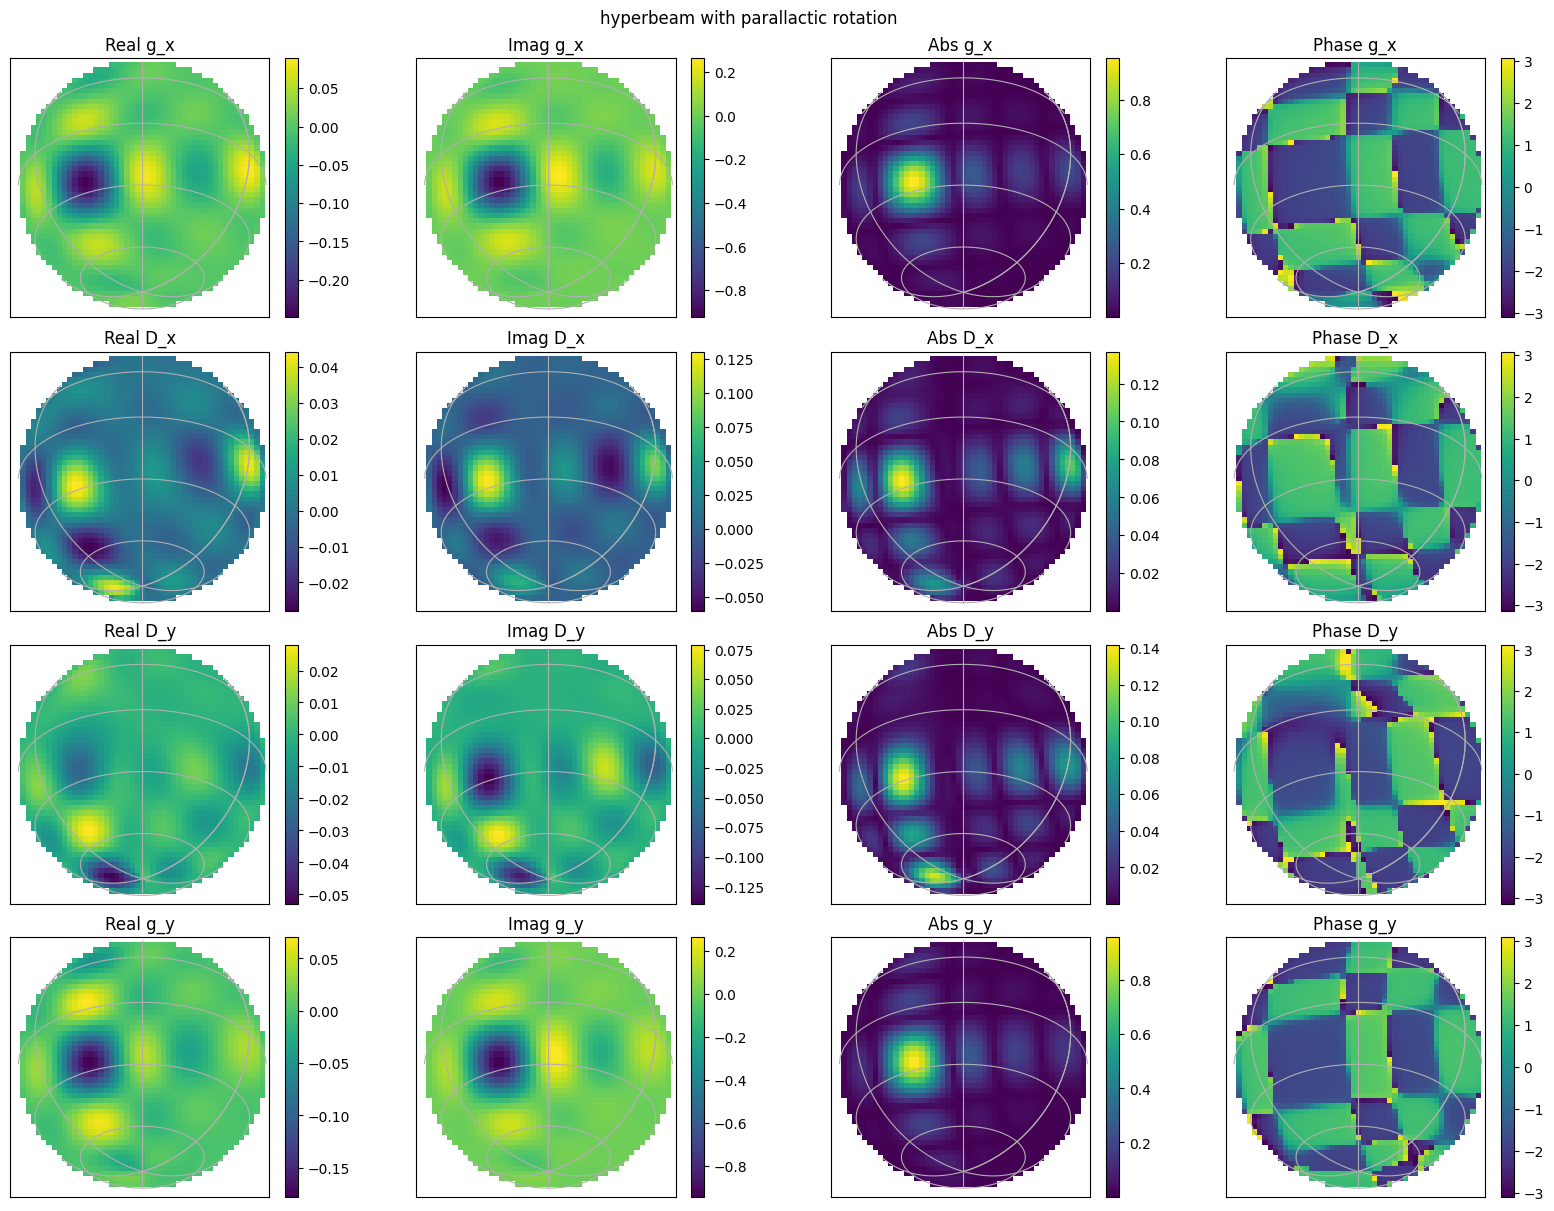

In [44]:
##use this erfa function to convert to azimuth and elevation
##were using degrees, but erfa uses rads, so convert here

for this_time in all_times:
    for freq in all_freqs:

        has = np.radians(this_time.sidereal_time('mean').value*15.0) - ras

        az_grid, els = erfa.hd2ae(has, decs, np.radians(MWA_LAT))

        za_grid = np.pi/2 - els

        beam = mwa_hyperbeam.FEEBeam(hdf5_file=os.environ["MWA_FEE_HDF5"])

        parallactic_rotation = True
        delays = [0,2,4,6,0,2,4,6,0,2,4,6,0,2,4,6]

        jones = beam.calc_jones_array(az_grid, za_grid, freq, delays, [1]*16, True, np.radians(MWA_LAT), parallactic_rotation)

        all_gx = jones[:,0]
        all_Dx = jones[:,1]
        all_Dy = jones[:,2]
        all_gy = jones[:,3]

        all_gx.shape = (nside, nside)
        all_Dx.shape = (nside, nside)
        all_Dy.shape = (nside, nside)
        all_gy.shape = (nside, nside)

        plot_jones_on_sky(all_gx, all_Dx, all_Dy, all_gy, wcs, title="hyperbeam with parallactic rotation")

## Interpolated beam
Can we use the interpolated Daniel Ung `.h5` file for highband? Let's try it.

In [47]:

from astropy.table import Column, Table
import numpy as np
import os

sing_ra = 15.0
sing_dec = -40.0

ras = [sing_ra]
decs = [sing_dec]

num_comps = len(ras)

c_ids = Column(data=np.array(['source']*num_comps), name='UNQ_SOURCE_ID', dtype='|S20')
c_names = Column(data=np.array([f'source_C{i:04d}' for i in range(num_comps)]), name='NAME', dtype='|S20')

##Component position
c_ras = Column(data=ras, name='RA')
c_decs = Column(data=decs, name='DEC')

##This says we have a point source
c_comp_types = Column(data=np.array(['P']*num_comps, dtype='|S1'), name="COMP_TYPE", dtype='|S1')
##This says we have a Stokes I power-law SED
c_mod_types = Column(data=np.array(['pl']*num_comps, dtype='|S3'), name="MOD_TYPE", dtype='|S3')

##Set everything as a flat spectrum 1 Jy stokes I source. That way we can image it and see the beam pattern
c_stokes_I_ref = Column(data=np.ones(num_comps), name='NORM_COMP_PL')
c_stokes_I_SI = Column(data=np.zeros(num_comps), name='ALPHA_PL')


cols = [c_ids, c_names, c_ras, c_decs, c_comp_types, c_mod_types, c_stokes_I_ref, c_stokes_I_SI]

main_table = Table(cols)

single_cat = 'single_point.fits'

main_table.write(single_cat, format='fits', overwrite=True)


ra0=0.0
dec0=-26.7
date="2024-07-21T20:13:00"
primary_beam="uvbeam_MWA"
num_times=1
num_freq_chans=50
low_freq=167e+6
uvfits_name="interp_run_woden"
freq_reso=80e+3

args = []

interp_h5 = os.environ['MWA_FEE_HDF5_INTERP']

cmd = 'run_woden.py '

cmd += f'--ra0={sing_ra} '
cmd += f'--dec0={-sing_dec} '
cmd += f'--metafits_filename=../../examples/metafits/1125949472_metafits.fits '
cmd += f'--output_uvfits_prepend={uvfits_name} '
cmd += f'--primary_beam={primary_beam} '
cmd += f'--freq_res={freq_reso} '
cmd += f'--band_nums=1 '
cmd += f'--num_time_steps={num_times} '
cmd += f'--IAU_order '
cmd += f'--cat_filename={single_cat} '
cmd += f'--lowest_channel_freq={low_freq} '
cmd += f'--num_freq_channels={num_freq_chans} '
cmd += f'--time_res=2 '
cmd += f'--num_threads=1 '
cmd += f'--hdf5_beam_path={interp_h5} '

call(cmd, shell=True)

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


2025-04-04 16:44:37 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                                 You are using wodenpy version/git hash: a43c383
                                 
2025-04-04 16:44:37 - INFO - Input arguments after parsing:
                             	Phase centre: 15.00000, 40.00000 deg
                             	Array central latitude: -26.703 deg
                             	Array central longitude: 116.671 deg
               

0

In [48]:
coarse_h5 = os.environ['MWA_FEE_HDF5']

uvfits_name = 'coarse_run_woden'

cmd = 'run_woden.py '

cmd += f'--ra0={sing_ra} '
cmd += f'--dec0={-sing_dec} '
cmd += f'--metafits_filename=../../examples/metafits/1125949472_metafits.fits '
cmd += f'--output_uvfits_prepend={uvfits_name} '
cmd += f'--primary_beam={primary_beam} '
cmd += f'--freq_res={freq_reso} '
cmd += f'--band_nums=1 '
cmd += f'--num_time_steps={num_times} '
cmd += f'--IAU_order '
cmd += f'--cat_filename={single_cat} '
cmd += f'--lowest_channel_freq={low_freq} '
cmd += f'--num_freq_channels={num_freq_chans} '
cmd += f'--time_res=2 '
cmd += f'--num_threads=1 '
cmd += f'--hdf5_beam_path={coarse_h5} '

call(cmd, shell=True)

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


2025-04-04 16:48:12 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                                 You are using wodenpy version/git hash: a43c383
                                 
2025-04-04 16:48:12 - INFO - Input arguments after parsing:
                             	Phase centre: 15.00000, 40.00000 deg
                             	Array central latitude: -26.703 deg
                             	Array central longitude: 116.671 deg
               

0

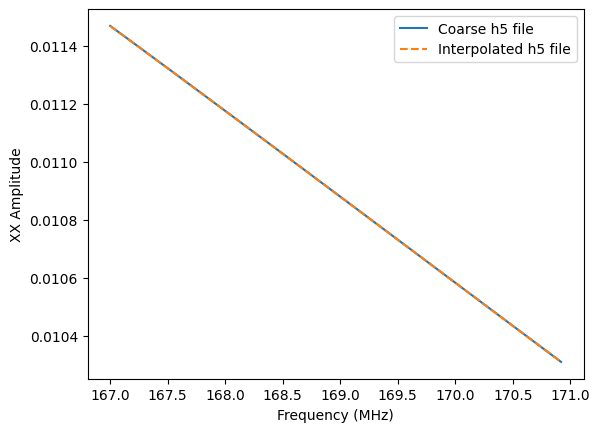

In [52]:
xx_interp, xy_interp, yx_interp, yy_interp = read_uvfits('interp_run_woden_band01.uvfits')
xx_coarse, xy_coarse, yx_coarse, yy_coarse = read_uvfits('coarse_run_woden_band01.uvfits')

freqs = np.arange(low_freq, low_freq + num_freq_chans*freq_reso, freq_reso)

xx_abs = np.abs(xx_coarse[0])
plt.plot(freqs/1e+6, xx_abs, label='Coarse h5 file')

xx_abs = np.abs(xx_interp[0])
plt.plot(freqs/1e+6, xx_abs, '--', label='Interpolated h5 file')
plt.xlabel('Frequency (MHz)')
plt.ylabel('XX Amplitude')
plt.legend()
plt.show()


Now, by default, `UVBeam` already interpolates the beam over frequency, so not surprisingly, these look the same. But the interpolated file beam is so so much slower and uses a huge amount of RAM. So I would suggest never using it with `UVBeam`.